# Bayesian hierarchical calibration models
While some calibrations can be established _once and for all_, there exists also the opposite extreme where (some) calibration parameters must be estimated alongside the process model.

For simplicity let's assume the following scenario:

* A linear relationship between independent/dependent variable in the measurement system.
* A batch-effect on the intercept parameter of the calibration.
* A "production process" that is a 1st order chemical rection. This can be described by $P(t) = S_0 \cdot (1 - e^{-t \cdot k})$.
* One "production process" experiment was performed, with samples taken at 5 time points.
* The product concentrations were measured in three batches, each having a different calibration intercept.

In [1]:
import arviz
import numpy
import calibr8
import pymc as pm
from matplotlib import pyplot

## Create the models

In [2]:
class LinearCalibration(calibr8.ContinuousUnivariateModel, calibr8.NormalNoise):
    def __init__(self):
        super().__init__(
            independent_key="P",
            dependent_key="readout",
            theta_names=["intercept", "slope", "sigma"],
        )
        
    def predict_dependent(self, x, *, theta=None):
        if theta is None:
            theta = self.theta_fitted
        intercept, slope, sd = theta[0], theta[1], theta[2]
        return calibr8.polynomial(x, [intercept, slope]), sd
    
def predict_P(S0, k, time):
    return S0 * (1 - numpy.exp(-time * k))
    
# Create the raw calibration model. We will use it to generate data.
cmodel = LinearCalibration()

## Simulate a dataset
For the purpose of this example, we're generating 

In [3]:
time = numpy.array([5, 15, 30, 60])  # seconds
true_S0 = 5.0                        # mM
true_k = 0.05                        # 1/s
true_intercepts = [0.15, 0.45, 0.28] # arbitrary units [a.u.]
true_slope = 0.3                     # a.u./mM
true_sigma = 0.08                    # a.u.
rng = numpy.random.RandomState(20211118)

dataset = {}
for ib, intercept in enumerate(true_intercepts):
    batch_id = f"batch #{ib+1}"
    # Simulate product concentrations
    P = predict_P(true_S0, true_k, time)
    
    # Simulate measurement readouts
    mu, sd = cmodel.predict_dependent(P, theta=[intercept, true_slope, true_sigma])
    dataset[batch_id] = cmodel.scipy_dist.rvs(
        **cmodel.to_scipy(mu, sd),
        random_state=rng,
    )
    
dataset

{'batch #1': array([0.57288426, 1.009389  , 1.22126874, 1.5490391 ]),
 'batch #2': array([0.85039   , 1.21933846, 1.73710129, 1.79041372]),
 'batch #3': array([0.64525864, 1.04893182, 1.43234941, 1.67851469])}

When visualizing the data, we can see a clear difference between the three batches.

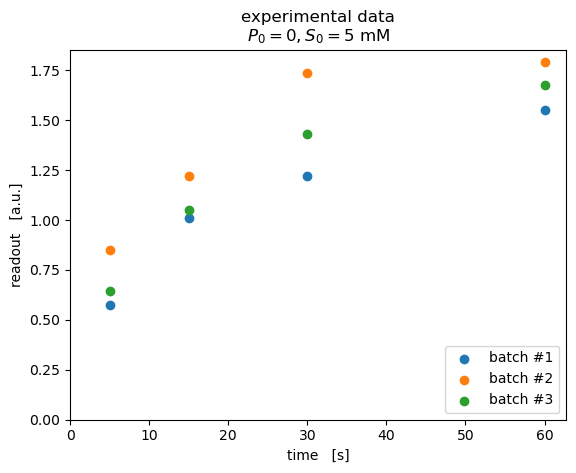

In [4]:
fig, ax = pyplot.subplots(dpi=100)

for batch_id, y_obs in dataset.items():
    ax.scatter(time, y_obs, label=batch_id)
ax.legend(loc="lower right")
ax.set(
    xlim=(0, None),
    ylim=(0, None),
    xlabel="time   [s]",
    ylabel="readout   [a.u.]",
    title="""experimental data\n$P_0=0, S_0=5\ \mathrm{mM}$"""
)
pyplot.show()

## Building the Bayesian model
For analyzing our data, we should think about how it was generated.
For every bit of information about the experimental setup we have to specify a _prior probability_ distribution to be used in the model.

We started with an initial product concentration of exactly zero ($P_0=0\ mM$).

The reaction was started with 5 mM of substrate, but it was hard to handle, so we might have gotten the concentration wrong by ~5 %.

$$ S_0 \sim \mathrm{LogNormal}(log(5), 0.05) $$

The chemical reaction is a 1st order reaction.

$$ P(t) = S_0 \cdot (1 - e^{-t \cdot k}) $$

From literature we expect a rate coefficient of around 0.1/s. It can only be positive.

$$ k \sim \mathrm{HalfNormal}(0.1) $$

In this example we don't have a separate calibration dataset, or separately fitted calibration model.
But from previous studies we have some prior information to fill the gaps in the final model:

We expect an intercept around 0.3 ± 0.2 a.u.

$$\mathrm{intercept} \sim \mathcal{N}(0.3, 0.2)$$

But there's a batch effect, so the actual intercepts may vary 0.1 a.u., but they're centered around the intercept we would expect on average.
With this, our "intercept" variable is a so-called _hyperprior_ or _group mean prior_ for the batch-wise intercept.
This makes the model a _hierarchical_ Bayesian model.

$$\mathrm{intercept_{batch}} \sim \mathcal{N}(\mathrm{intercept}, 0.1)$$

The slope should be around 0.5 a.u./mM.

$$\mathrm{slope} \sim \mathcal{N}(0.5, 0.5)$$

The standard deviation of the observations should be around 0.1 a.u.

$$ \mathrm{sigma} \sim \mathrm{LogNormal}(log(0.1), 0.1) $$

Note that we could also have obtained a separate calibration dataset and left only the intercept parameter to be estimated from our dataset of interest.

What follows now is the PyMC model definition.
It reads very much like the mathematical notation from above and can be visualized as a so-called _plate model_ showing how the variables are connected and which shapes they have.

c:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\dibecs_6.3.0\lib\site-packages\pymc\distributions\logprob.py:168: FutureWarning: joint_logp has been deprecated, use model.logp instead
  warnings.warn(
c:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\dibecs_6.3.0\lib\site-packages\pymc\util.py:501: FutureWarning: The tag attribute total_size is deprecated. Use model.rvs_to_total_sizes[rv] instead
  warnings.warn(
c:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\dibecs_6.3.0\lib\site-packages\pymc\util.py:501: FutureWarning: The tag attribute value_var is deprecated. Use model.rvs_to_values[rv] instead
  warnings.warn(
c:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\dibecs_6.3.0\lib\site-packages\pymc\util.py:501: FutureWarning: The tag attribute transform is deprecated. Use model.rvs_to_transforms[rv] instead
  warnings.warn(


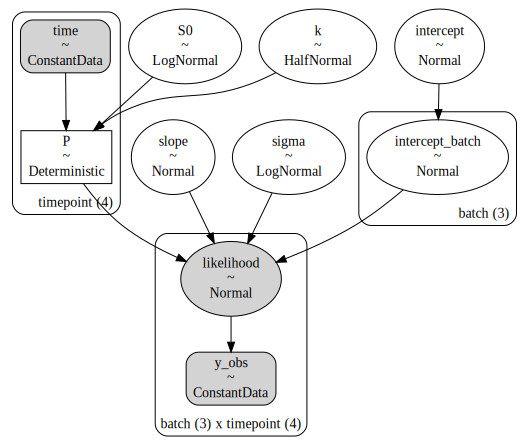

In [5]:
# This model code uses the "coords" feature of PyMC models to track, for example, the names of batches.
with pm.Model(coords={
    "batch": list(dataset.keys()),
    "timepoint": list(numpy.arange(len(time))),
}) as pmodel:
    t = pm.ConstantData("time", time, dims="timepoint")
    y_obs = pm.ConstantData("y_obs", numpy.array(list(dataset.values())), dims=("batch", "timepoint"))
    
    # Process model
    k = pm.HalfNormal("k", 0.1)
    S0 = pm.Lognormal("S0", mu=numpy.log(5.0), sigma=0.05)
    P = pm.Deterministic("P", predict_P(S0, k, t), dims="timepoint")
    
    # Calibration model
    intercept = pm.Normal("intercept", mu=0.3, sigma=0.2)
    intercept_batch = pm.Normal("intercept_batch", mu=intercept, sigma=0.1, dims="batch")
    slope = pm.Normal("slope", mu=0.5, sigma=0.5)
    sigma = pm.Lognormal("sigma", mu=numpy.log(0.1), sigma=0.1)
    
    # Observing the product concentrations with the calibration model
    cmodel.loglikelihood(
        name="likelihood",
        y=y_obs,
        # This 👇 broadcasts the product concentration over all batches.
        x=P[None, :],
        dims=("batch", "timepoint"),
        # Pass priors for the calibration model parameters:
        theta=[intercept_batch[:, None], slope, sigma]
        # This slicing here 👆 makes the intercept into a column-vector,
        # such that it's shape broadcasting aligns with P[None, :] from above.
    )
    
pm.model_to_graphviz(pmodel)

We can now run MCMC, specifically PyMC's implementation of HMC-NUTS, to obtain samples from the posterior probability distribution of our model variables.

In [6]:
with pmodel:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [k, S0, intercept, intercept_batch, slope, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 73 seconds.


## Visualization of the results
Using the [ArviZ](https://arviz-devs.github.io/arviz/examples/index.html) library we can quickly create pretty plots of our model posteriors.
The following one shows the highest density intervals (HDI) where we believe our model variables lie with a 99 % probability.

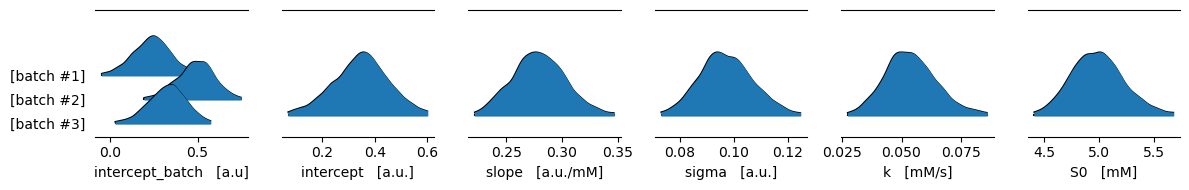

In [7]:
var_names = ["intercept_batch", "intercept", "slope", "sigma", "k", "S0"]
units = ["a.u", "a.u.", "a.u./mM", "a.u.", "mM/s", "mM"]
fig, axs = pyplot.subplots(ncols=len(var_names), figsize=(12, 12 / len(var_names)), dpi=100)
for ax, name, unit in zip(axs, var_names, units):
    arviz.plot_forest(
        idata, ax=ax, var_names=[name], 
        kind="ridgeplot", combined=True,
        hdi_prob=0.99
    )
    # Remove redundant texts from the automatic yticklabels
    ax.set_yticklabels([
        ytext._text.replace(name, "").replace(":", "")
        for ytext in ax.get_yticklabels()
    ])
    # instead put the name and axis 
    ax.set_xlabel(f"{name}   [{unit}]")
fig.tight_layout()
pyplot.show()

We can also plot the product concentration over time.
The posterior samples in our model are only at 5 time points, so to get a smoother plot let's re-predict product concentrations from the $S_0$ and $k$ posterior samples.

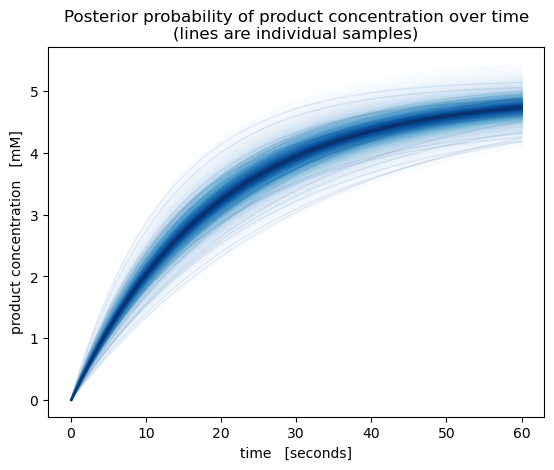

In [8]:
# Combine posterior samples from all MCMC chains
pst = idata.posterior.stack(sample=("chain", "draw"))

# Predict product concentrations with higher time resolution
time_dense = numpy.linspace(0, 60, 100)
P_dense = predict_P(
    S0=pst.S0.values[:, None],
    k=pst.k.values[:, None],
    time=time_dense
)

fig, ax = pyplot.subplots(dpi=100)

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_dense,
    samples=P_dense,
    palette=pyplot.cm.Blues,
)
ax.set(
    title="Posterior probability of product concentration over time\n(lines are individual samples)",
    ylabel="product concentration   [mM]",
    xlabel="time   [seconds]",
)

pyplot.show()

## Conclusion
In this example we have seen how to analyze experimental data containing batch-effects.
We built a Bayesian model with PyMC, levaraging the tensors-compatibility of the `calibr8.CalibrationModel.loglikelihood` to construct a hierarchical calibration model that captures batch-effects in product concentration measurement.

As a result, we have not only quantified uncertainty in the rate coefficient of our chemical reaction, but also the uncertainties in product concentration over time, initial substrate concentration and all parameters of the calibration model.

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Dec 13 2022

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.6.0

matplotlib: 3.6.2
numpy     : 1.23.4
arviz     : 0.14.0
calibr8   : 7.0.0
pymc      : 4.4.0
sys       : 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]

Watermark: 2.3.1

